In [135]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

Функции для подсчета показателей качества классификации

In [136]:
def accuracy(y, a):
    """Compute accuracy"""
    return np.all(y == a, axis=1).sum() / y.shape[0]


def recall(y, a):
    """Compute recall (TPR, sensivity) for each class"""
    
    rec = np.sum(a * y, axis=0) / np.sum(y, axis=0)
    rec[np.isnan(rec)] = 1.0
    return rec


def precision(y, a):
    """Compute recall for each class"""
    
    pr = np.sum(a * y, axis=0) / np.sum(a, axis=0)
    pr[np.isnan(pr)] = 1.0
    return pr


def specificity(y, a):
    """Compute specificity (TNR, recall for negative class)"""
    
#     specificity = np.sum((1 - a) * (1 - y), axis=0) / np.sum(1 - y, axis=0)
#     specificity[np.isnan(specificity)] = 1.0
    return recall(1 - y, 1 - a)


def balanced_accuracy_score(y, a):
    """mean(R)"""
    
    return np.mean(recall(y, a))


def balanced_accuracy_score2(y, a):
    """mean(min(P, R))"""
    
    return np.mean(np.minimum(recall(y, a), precision(y, a)))


def balanced_accuracy_score3(y, a):
    """mean(min(sens, spec))"""
    
    return np.mean(np.minimum(recall(y, a), specificity(y, a)))


def generate_y(class_prob, n=1000):
    """Generate y"""
    
    n_classes = len(class_prob)
    y = np.zeros((n, n_classes), dtype=int)
    y[np.arange(n), np.random.choice(np.arange(n_classes), size=n, p=class_prob)] = 1
    return y
    

Сравним наши показатели качества на рассмотренной на лекции задаче разделения объектов, сгенерированных из нормальных распределений с разными матожиданиями

In [137]:
# Генерация точек из двух нормальных распределений с матожиданиями 0 и 1
def generate_data(n=5000, n_0=2500):
    np.random.seed(0)
    y = np.zeros((n, 2), dtype=int)
    y[: n_0, 0] = 1
    y[n_0:, 1] = 1

    X = np.zeros((n, 1))
    X[: n_0] = np.random.normal(loc=0, size=(n_0, 1))
    X[n_0:] = np.random.normal(loc=1, size=(n - n_0, 1))
    
    return X, y 


def plot_scores(X, y, two_class=False):
    acc = []
    bas = []
    bas2 = []
    bas3 = []
    if two_class:
        y = y[:, 1].reshape(-1, 1)
    thrs = np.linspace(-1., 2., 20)
    for thr in thrs:
        a = (X > thr).astype(int)
        if not two_class:
            a = np.hstack((1 - a, a))
        acc.append(accuracy(y, a))
        bas.append(balanced_accuracy_score(y, a))
        bas2.append(balanced_accuracy_score2(y, a))
        bas3.append(balanced_accuracy_score3(y, a))
    
    plt.figure(figsize=(10, 7))
    plt.plot(thrs, bas, c='r', label='mean(R)', linewidth=3)
    plt.plot(thrs, bas2, c='g', label='mean(min(P, R))', linewidth=3)
    plt.plot(thrs, bas3, c='b', label='mean(min(sens, spec))', linewidth=3)
    for b in [bas, bas2, bas3]:
        idx = np.argmax(b)
        plt.plot([thrs[idx]], [b[idx]], '*')
    plt.xlabel('Порог')
    plt.legend(fontsize=14)
#     plt.show()

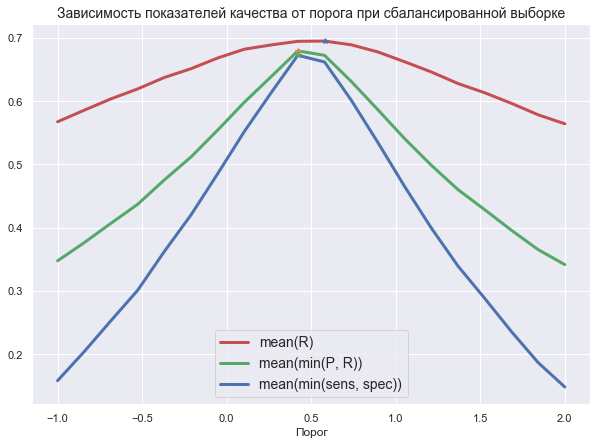

In [138]:
plot_scores(*generate_data(10000, 5000))
plt.title('Зависимость показателей качества от порога при сбалансированной выборке', fontsize=14)
plt.show()

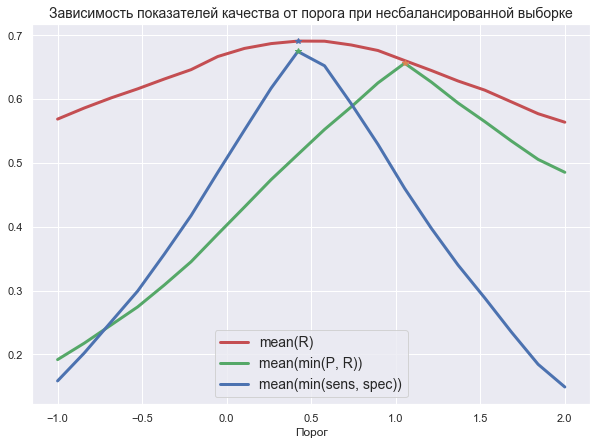

In [139]:
plot_scores(*generate_data(10000, 8000))
plt.title('Зависимость показателей качества от порога при несбалансированной выборке', fontsize=14)
plt.show()

Как видно из графиков выше, усредненная полнота вместе со усредненным минимумом от чувствительности и специфичности не зависят от сбалансированности классов. В то же время усредненный минимум от точности и полноты существенно меняет положение максимума при появлении дисбаланса классов.

Дальше рассмотрим поведение показателей качества в задаче классификации на три класса при зафиксированной доле правильно классифицированных объектов (accuracy). 

In [140]:
acc = 0.9
n = 9000
y = np.zeros((n, 3), dtype=int)
# Нулевому классу принадлежит половина объектов, первому и второму - по четверти
y[np.arange(n), np.array([0] * (n//2) + [1] * (n//4) + [2] * (n//4))] = 1
pos = [(0, n//2), (n//2, 3 * (n//4)), (3 * (n//4), n)]

Попробуем теперь построить график зависимости показателей качества от доли ошибок, содержащихся в наибольшем классе.

In [141]:
def compute_scores(y, n_errors, pos):
    a = np.zeros((n, 3), dtype=int)
    np.random.seed(0)
    for i in range(3):
        p = [0.] * 3
        p[i] = 1. - n_errors[i] / (pos[i][1] - pos[i][0])
        p[(i+1) % 3] = (1 - p[i]) / 2
        p[(i+2) % 3] = (1 - p[i]) / 2
        a2 = np.random.choice([0, 1, 2], p=p, size=(pos[i][1] - pos[i][0],))
        a[np.arange(pos[i][0], pos[i][1]), a2] = 1
    
    return balanced_accuracy_score(y, a), balanced_accuracy_score2(y, a), balanced_accuracy_score3(y, a)

In [142]:
total_errors = int((1. - acc) * n)
bas = []
bas2 = []
bas3 = []
for alpha in np.linspace(0., 1., 20):
    n0_errors = int(alpha * total_errors)
    n1_errors = (total_errors - n0_errors) // 2
    b, b2, b3 = compute_scores(y, [n0_errors, n1_errors, n1_errors], pos)
    bas.append(b)
    bas2.append(b2)
    bas3.append(b3)

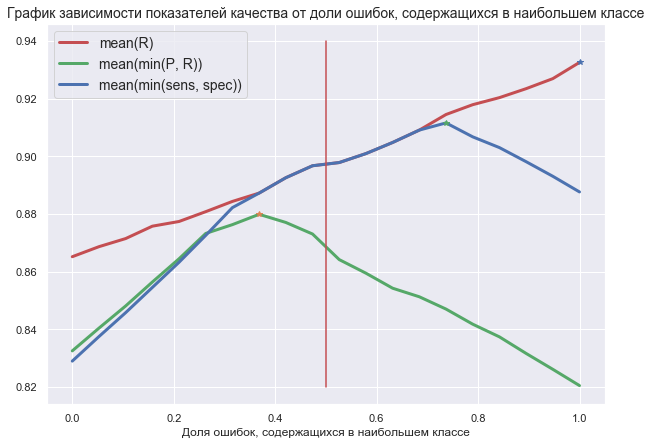

In [143]:
plt.figure(figsize=(10, 7))
plt.plot(np.linspace(0., 1., 20), bas, c='r', label='mean(R)', linewidth=3)
plt.plot(np.linspace(0., 1., 20), bas2, c='g', label='mean(min(P, R))', linewidth=3)
plt.plot(np.linspace(0., 1., 20), bas3, c='b', label='mean(min(sens, spec))', linewidth=3)
plt.plot([0.5, 0.5], [0.82, 0.94], c='r')
for b in [bas, bas2, bas3]:
    idx = np.argmax(b)
    plt.plot([np.linspace(0., 1., 20)[idx]], [b[idx]], '*')
plt.xlabel('Доля ошибок, содержащихся в наибольшем классе')
plt.legend(fontsize=14)
plt.title('График зависимости показателей качества от доли ошибок, содержащихся в наибольшем классе', fontsize=14)
plt.show()

Красная вертикальная линия соответствует случаю, когда ошибки распределены равномерно (доля ошибок, содержащихся в наибольшем классе равна доле объектов в этом классе)

Из этого графика мы видим, что усредненная полнота вместе со усредненным минимумом от чувствительности и специфичности при одинаковой доле правильно классифицированных объектов предпочитают, чтобы большая доля ошибок содержалась в большем классе (для них аргмаксимум больше 0.5 --- доли объектов большего класса). Причем усредненная полнота достигает максимума, когда все ошибки содержатся в наибольшем классе, в то время как усредненный минимум от чувствительности и специфичности с некоторого момента начинает убывать. Также интересно, что усредненный минимум от точности и полноты достигает максимума при большем количестве ошибок в малых классах.